<a href="https://colab.research.google.com/github/laysfreitas/Covid_Dados/blob/main/LSTM_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importações**

In [28]:
import requests
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# **Carregando os dados**

In [29]:
GO = pd.read_csv('GO_Final.csv',index_col=0)

In [30]:
GO.head()

,saidaConfirmadaObitos,casosNovos,Doses
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,2.0,130.0,0.0
3,56.0,1432.0,0.0
4,190.0,5842.0,0.0


# **Preparando os dados**

In [31]:
X = GO[['Doses', 'casosNovos']].values
X = (X - np.min(X)) / (np.max(X) - np.min(X))

In [32]:
#X

In [33]:
# Conjunto de pontos passados para o modelo LSTM

window = 10

n = X.shape[0]

# Separar os dados em 80% treino e 20% teste
last = int(n/5.0)
Xtrain = X[:-last]
Xtest = X[-last-window:]

# Armazenar window números de pontos em uma sequência
xin = []
next_x1 = []
next_x2 = []

for i in range(window, len(Xtrain)):
    xin.append(Xtrain[i-window:i])
    next_x1.append(Xtrain[i])
    next_x2.append(GO['saidaConfirmadaObitos'].values[i])  # Adicionando 'saidaConfirmadaObitos'

# Transformar os dados para o formato LSTM
xin, next_x1, next_x2 = np.array(xin), np.array(next_x1), np.array(next_x2)
xin = xin.reshape(xin.shape[0], xin.shape[1], 2)
#print(xin[0:5])

# **Modelo LSTM**

Esse código cria um modelo Sequential de Rede Neural Artificial com 3 camadas LSTM, com 50 unidades cada, seguidas por duas camadas de Dropout (com taxa de descarte de 0,2), e finalmente, uma camada densa com uma unidade. A função de perda utilizada é a "mean_squared_error" e o otimizador escolhido é o "adam". A forma da entrada da camada LSTM é definida como uma matriz tridimensional de formato (xin.shape[1], 2), onde xin.shape[1] representa o comprimento da janela de tempo.


* Mean Squared Error (MSE): A função MSE calcula a média dos erros ao quadrado entre as previsões e os valores reais. É amplamente utilizada em problemas de regressão.
* Mean Squared Logarithmic Error (MSLE): A MSLE é semelhante à MSE, mas aplica a logaritmo aos erros antes de calcular a média. Isso é útil para problemas onde as diferenças entre as previsões e os valores reais são grandes.
* Adam: um otimizador baseado em gradiente que utiliza técnicas de adaptação de taxa de aprendizado
* RMSprop: um otimizador baseado em gradiente que se concentra na descida de gradiente em direção às direções de descida de gradiente mais rápidas
*   Item da lista

Verificar o score R². Se o score R² for muito alto nos dados de treinamento, mas muito baixo nos dados de validação, é provável que o modelo esteja sofrendo de overfitting.

In [34]:
# Keras é uma interface do TensorFlow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Inicializar modelo LSTM

m = Sequential()
m.add(LSTM(units=40, return_sequences=True, input_shape=(xin.shape[1],2)))
m.add(Dropout(0.2))
m.add(LSTM(units=40))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')

Epoch 1/50
4/4 [==============================] - 5s 19ms/step - loss: 0.1324
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0702
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0551
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0621
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0589
Epoch 6/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0529
Epoch 7/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0470
Epoch 8/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0508
Epoch 9/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0499
Epoch 10/50
4/4 [==============================] - 0s 19ms/step - loss: 0.0464
Epoch 11/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0532
Epoch 12/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0474
Epoch 13/50
4/4 [==============================] - 0s 18ms/st

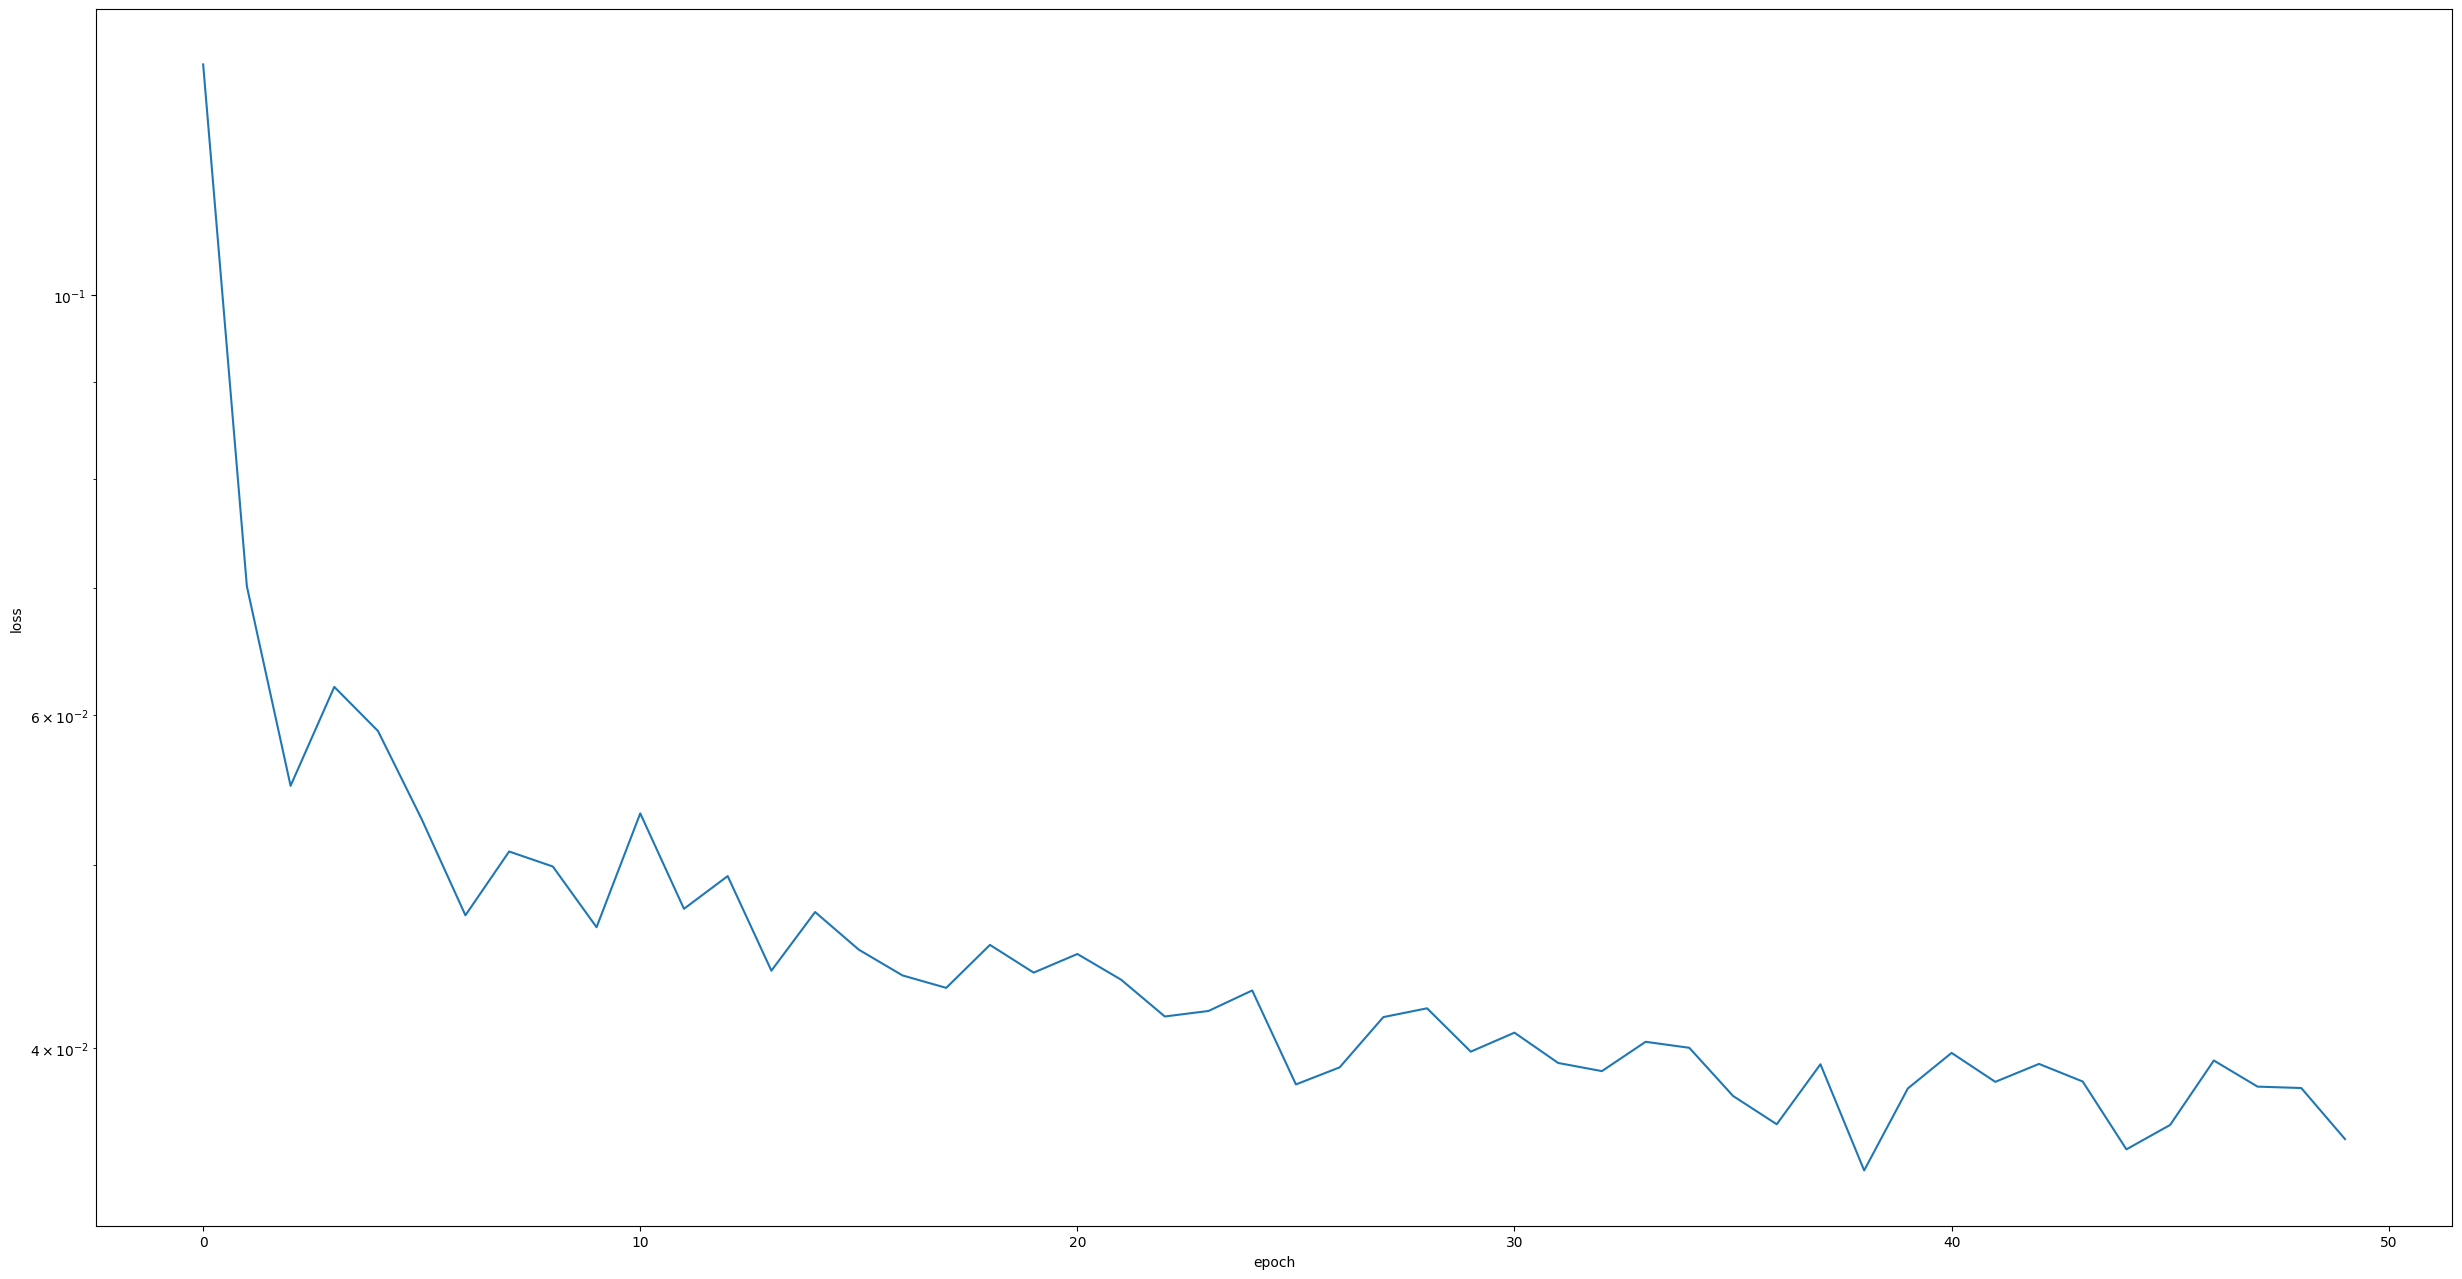

In [35]:
# Modelo LSTM fit

history = m.fit(xin, next_x1, epochs = 50, batch_size = 5, verbose = 1)

plt.figure(figsize=(30.4,15.8))
plt.ylabel('loss'); plt.xlabel('epoch')
plt.semilogy(history.history['loss'])

# **Validação**

1/1 [==============================] - 1s 825ms/step


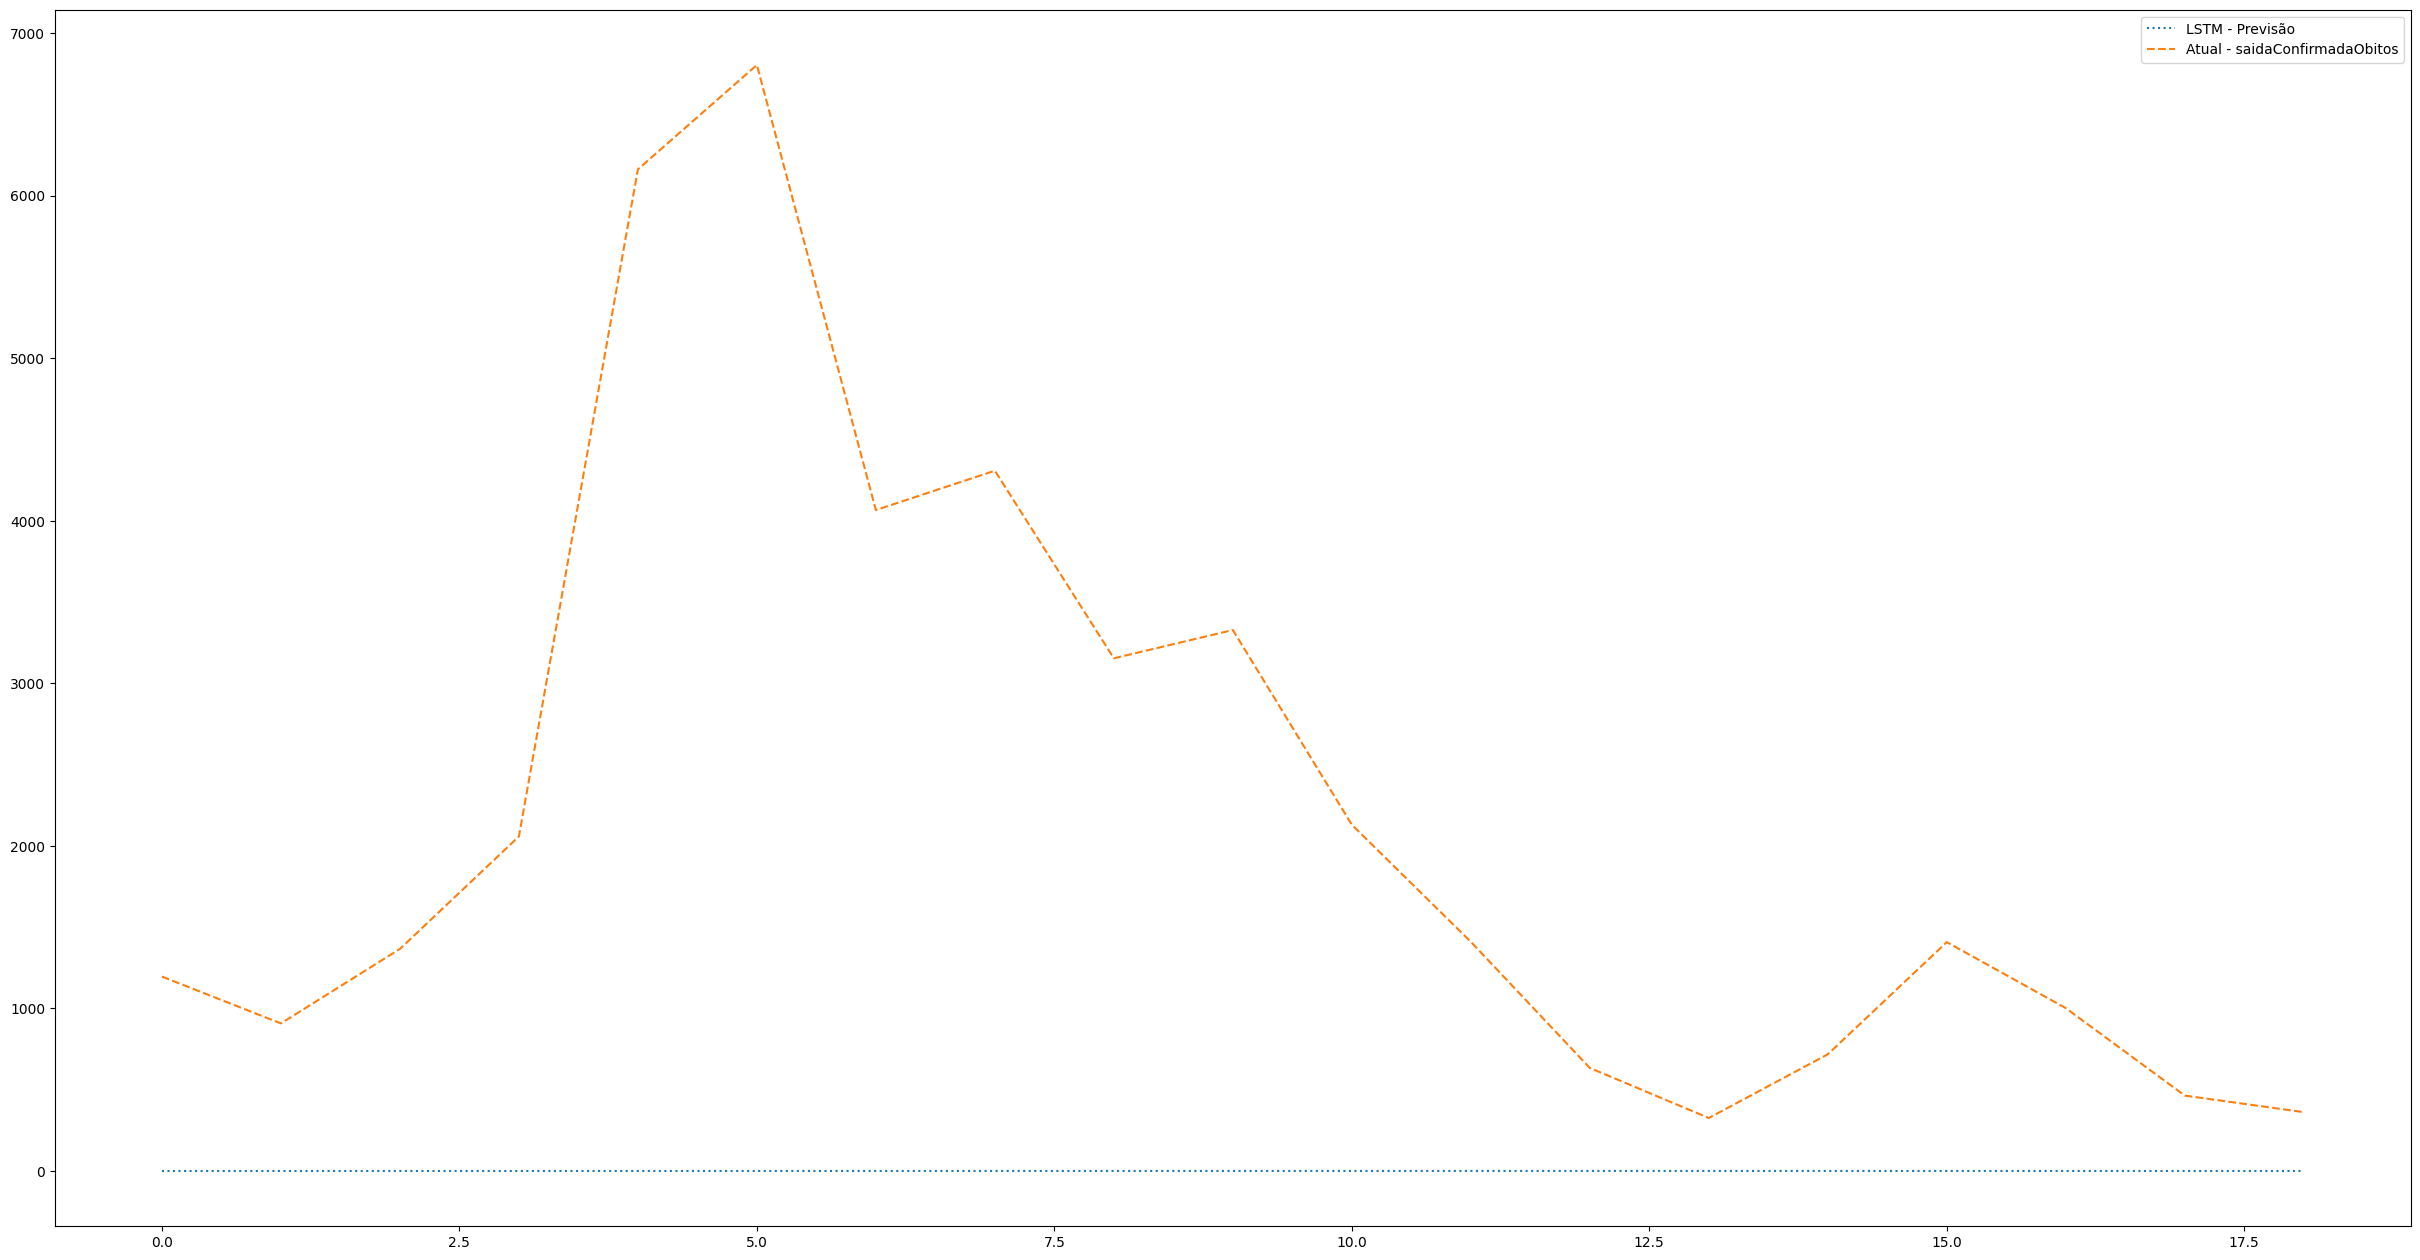

In [36]:
# Predizer o próximo valor (1 passo à frente)
X_pred = m.predict(xin)

# # Mostrar predição VS dados de teste atual
# plt.figure(figsize=(30.4, 15.8))
# plt.plot(X_pred, ':', label='LSTM - Previsão')
# plt.plot(next_x1, '--', label='Atual - casosNovos')
# plt.legend()

# Mostrar predição VS 'saidaConfirmadaObitos'
plt.figure(figsize=(30.4, 15.8))
plt.plot(X_pred, ':', label='LSTM - Previsão')
plt.plot(next_x2, '--', label='Atual - saidaConfirmadaObitos')
plt.legend()

# **Forecasting**

1/1 [==============================] - 0s 26ms/step


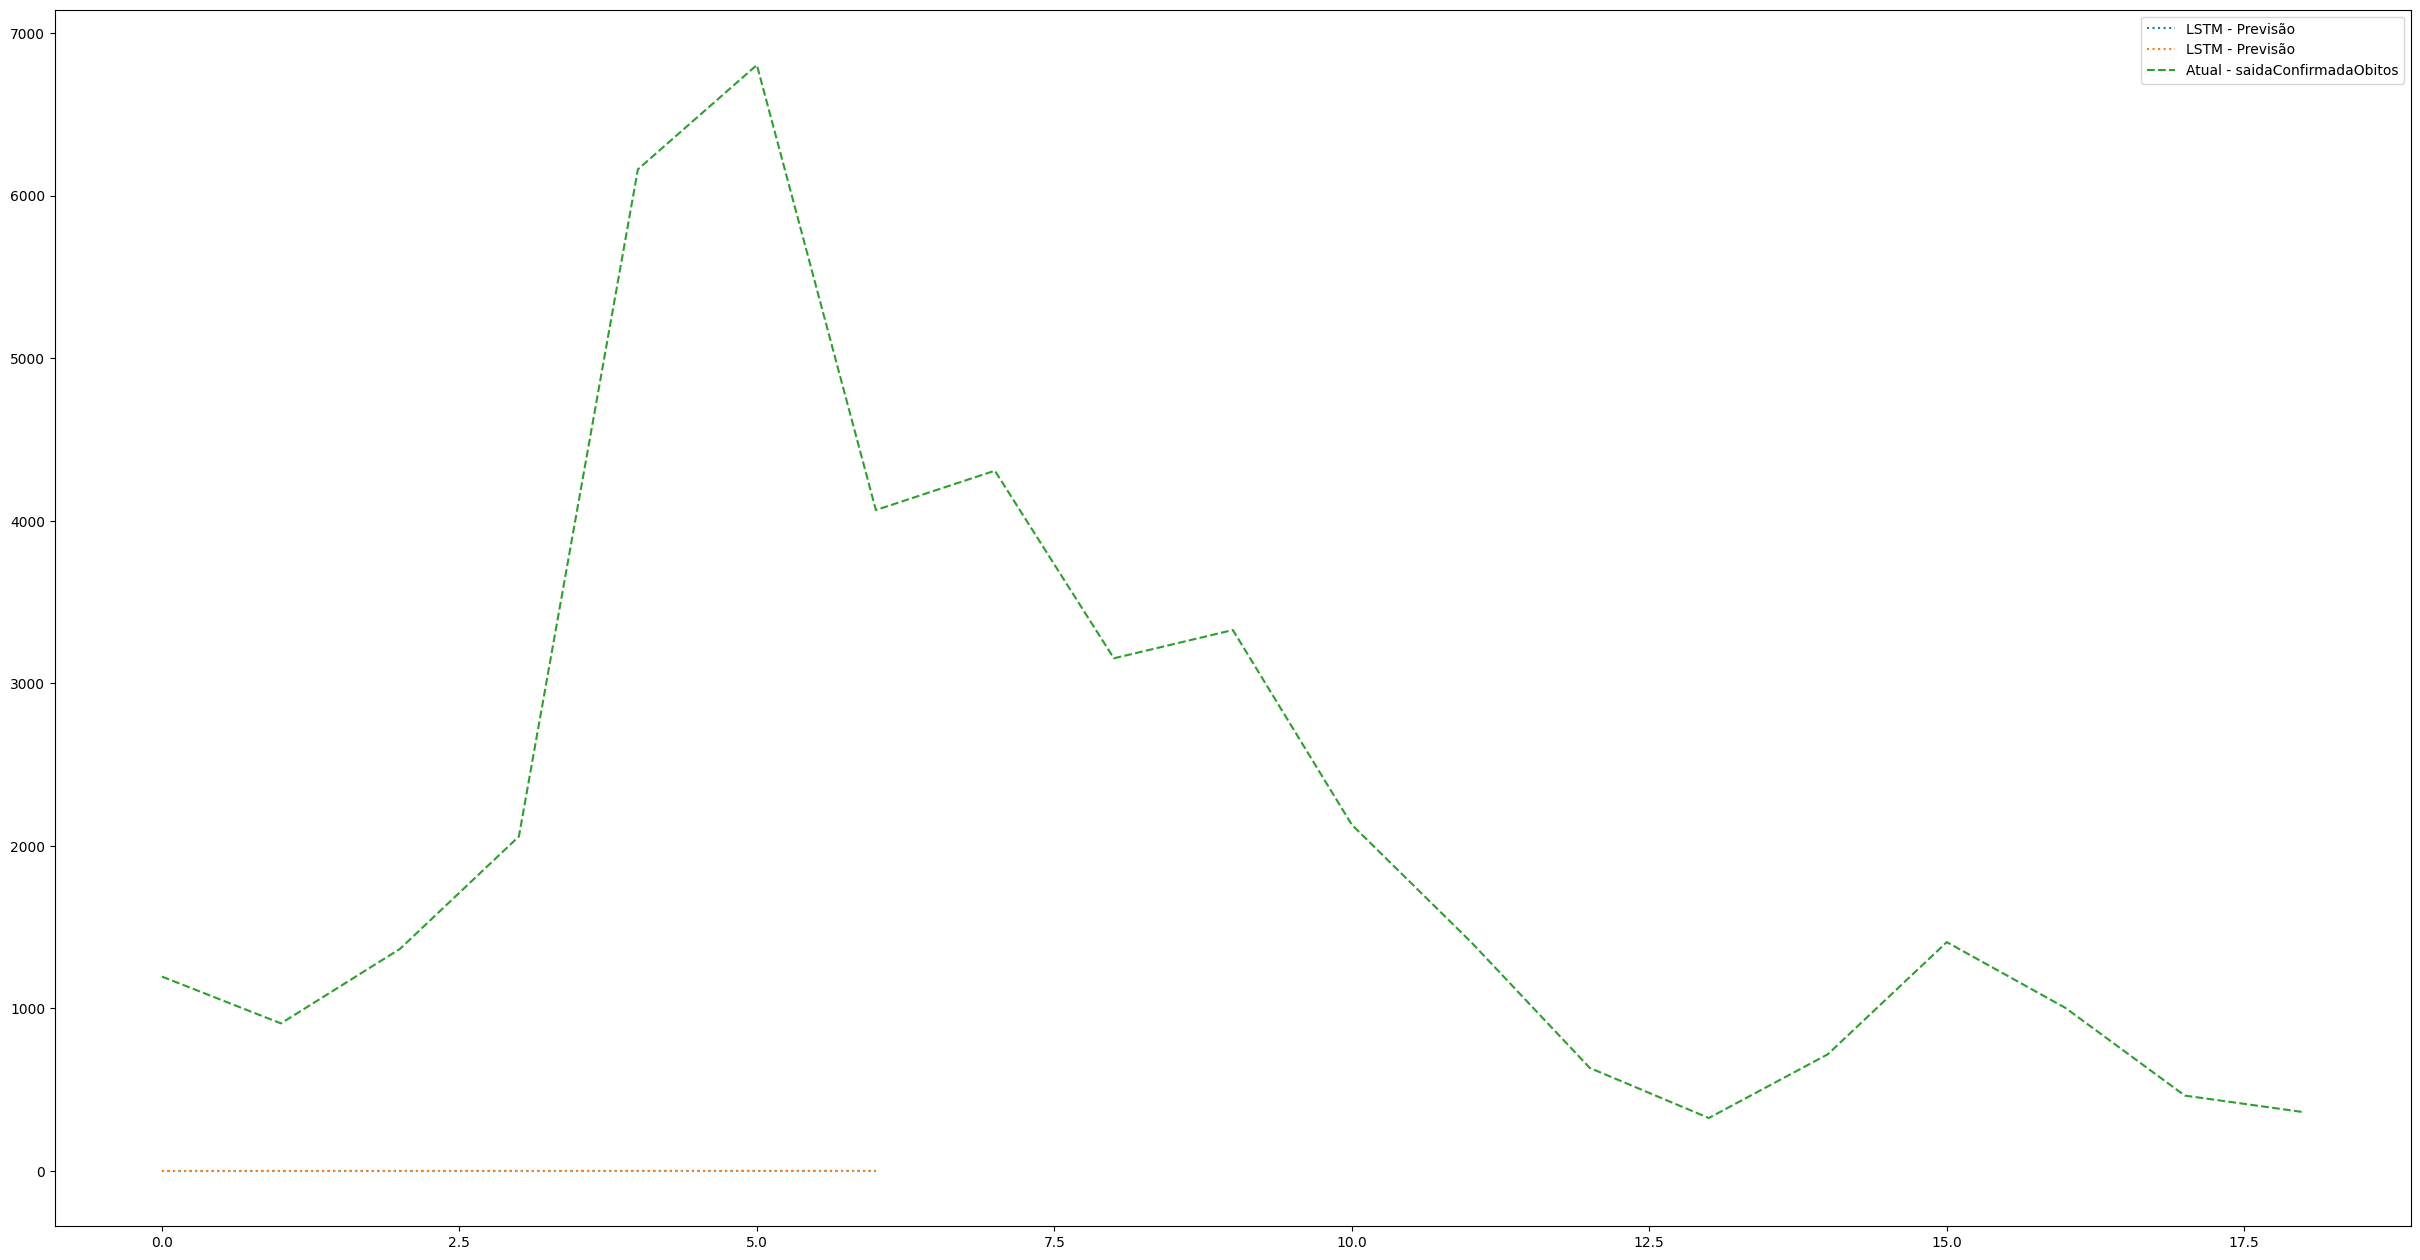

In [37]:
# Refinir as previsões usando janela deslizante
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].reshape((1, window, 2))
    X_pred[i] = m.predict(xin)

# Mostrar predição VS dados do teste atual (com janela deslizante)
plt.figure(figsize=(30.4, 15.8))
plt.plot(X_pred[window:], ':', label='LSTM - Previsão')
plt.plot(next_x2, '--', label='Atual - saidaConfirmadaObitos')
plt.legend()